# Statystyczne reguły decyzyjne - wykład 26.05.2018

Dla osób zainteresowanych: instrukcja korzystania z języka R w notatnikach Jupyter dostępna jest [tutaj](https://irkernel.github.io/). 

## 1. Metody oceny jakości modeli klasyfikacyjnych

Zacznijmy od prostego przykładu. Dla australijskich danych dotyczących wniosków o karty kredytowe (dostepnych [tutaj](http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/australian/australian.dat)) zbudujmy model orkreślający prawdopodobieństwo decyzji o odmowie wydania karty kredytowej. Zacznijmy od odpowiedniedgo przygotowania danych:

In [13]:
setwd("C:/Users/p/") #sciezka z dostepem do danych
library(ROCR) #biblioteka do graficznych metod oceny jakosci modeli klasyfikacyjnych 
library(pscl) #biblioteka do wyliczania wartosci pseudo-r2
library(caret) #biblioteka, ktora wykorzystujemy do wygenerowania macierzy klasyfikacji
library(nnet) #biblioteka do tworzenia sieci neuronowych
set.seed(1) #ustalamy stale ziarno losowe - pozwoli nam to otrzymac porownywalne wyniki

Loading required package: ggplot2
Error: package or namespace load failed for 'ggplot2' in loadNamespace(j <- i[[1L]], c(lib.loc, .libPaths()), versionCheck = vI[[j]]):
 there is no package called 'Rcpp'


ERROR: Error: package 'ggplot2' could not be loaded


In [3]:
DATA_SET <- read.table("australian.dat", header = F, sep = " ")
names(DATA_SET) <- c(paste("A", 1:14, sep = ""), "class")

head(DATA_SET)

A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,class
1,22.08,11.460,2,4,4,1.585,0,0,0,1,2,100,1213,0
0,22.67,7.000,2,8,4,0.165,0,0,0,0,2,160,1,0
0,29.58,1.750,1,4,4,1.250,0,0,0,1,2,280,1,0
0,21.67,11.500,1,5,3,0.000,1,1,11,1,2,0,1,1
1,20.17,8.170,2,6,4,1.960,1,1,14,0,2,60,159,1
0,15.83,0.585,2,8,8,1.500,1,1,2,0,2,100,1,1


In [4]:
DATA_SET <- read.table("australian.dat", header = F, sep = " ")
names(DATA_SET) <- c(paste("A", 1:14, sep = ""), "class")
DATA_SET$A4 <- ifelse(DATA_SET$A4 == 1, 0, 1)
DATA_SET$A12 <- ifelse(DATA_SET$A12 == 1, 0, 1)
DATA_SET$A14 <- log(DATA_SET$A14)
head(DATA_SET)

A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,class
1,22.08,11.460,1,4,4,1.585,0,0,0,1,1,100,7.100852,0
0,22.67,7.000,1,8,4,0.165,0,0,0,0,1,160,0.000000,0
0,29.58,1.750,0,4,4,1.250,0,0,0,1,1,280,0.000000,0
0,21.67,11.500,0,5,3,0.000,1,1,11,1,1,0,0.000000,1
1,20.17,8.170,1,6,4,1.960,1,1,14,0,1,60,5.068904,1
0,15.83,0.585,1,8,8,1.500,1,1,2,0,1,100,0.000000,1


Podzielmy je na zbiór trenujący i testowy:

In [5]:
TRAINING_FRACTION <- 0.5
training.set.indices <- (sample.int(nrow(DATA_SET)) / nrow(DATA_SET)
                         <= TRAINING_FRACTION)
train.set <- DATA_SET[training.set.indices, ]
test.set <- DATA_SET[!training.set.indices, ]

Oszacujmy nasz model. Będzie to regresja logistyczna z przyjętym bayesowskim kryterium informacyjnym ([BIC](https://en.wikipedia.org/wiki/Bayesian_information_criterion)) jako kryterium selekcji zmiennych:

In [6]:
full.logit <- glm(class ~ ., data = train.set, family = binomial)
BIC.logit <- step(full.logit, k = log(nrow(train.set)), trace = 0)

Selekcja zmiennych do modelu regresji logistycznej polega na wyborze takiego zestawu zmiennych objaśniających, który minimalizuje wyrażenie $BIC = -2\ln(L) + m\ln(n)$, gdzie $L$ to wartość funkcji wiarygodności, $m$ liczba zmiennych objaśniających a $n$ liczebność zbioru uczącego. Gdybyśmy chcieli zastosować kryterium informacyjne Akaike'go musielibyśmy podmienić $\ln(n)$ na 2.

Następnym krokiem jest ocena jakości zbudowanego modelu. Możemy do tego wykorzystać wartości współczynnika [$pseudo-R^2$](https://stats.idre.ucla.edu/other/mult-pkg/faq/general/faq-what-are-pseudo-r-squareds/):

In [7]:
pR2(BIC.logit)

llh      llhNull           G2     McFadden         r2ML         r2CU 
 -99.8454350 -238.4962516  277.3016332    0.5813543    0.5523631    0.7373971

Czy też wyznaczyć trafność predykcji:

In [8]:
fitted.results <- predict(BIC.logit,newdata=test.set,type='response')
fitted.results <- ifelse(fitted.results > 0.5,1,0)

misClasificError <- mean(fitted.results != test.set$class)
print(paste('Accuracy',1-misClasificError))



[1] "Accuracy 0.83768115942029"


Albo wygererować macierz klasyfikacji dla ustalonego progu odcięcia $T$ (w tym wypadku równego $0.5$):

In [9]:
confusionMatrix(test.set$class, fitted.results)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 166  34
         1  22 123
                                         
               Accuracy : 0.8377         
                 95% CI : (0.7945, 0.875)
    No Information Rate : 0.5449         
    P-Value [Acc > NIR] : <2e-16         
                                         
                  Kappa : 0.6706         
 Mcnemar's Test P-Value : 0.1416         
                                         
            Sensitivity : 0.8830         
            Specificity : 0.7834         
         Pos Pred Value : 0.8300         
         Neg Pred Value : 0.8483         
             Prevalence : 0.5449         
         Detection Rate : 0.4812         
   Detection Prevalence : 0.5797         
      Balanced Accuracy : 0.8332         
                                         
       'Positive' Class : 0              
                                         

Nie zawsze jednak same statystyki są wystarczające. Wizualizacja danych pozwala lepiej zrozumieć otrzymane wyniki i porównać je z wynikami otrzymanymi dla innych modeli. Dlatego też narysujemy 4 wykresy będące najpowszechniej wykorzystywanymi graficznymi metodami oceny jakości dopasowania.

### 1.1. Krzywa <i>Gain</i>

Pierwszą krzywą, którą wygenerujemy jest krzywa <i>gain</i>. Dla zadanego $T \in \mathcal{R}$ przedstawia ona uporządkowane pary $(RPP(T),TPR(T))$. $RPP(T)$ oznacza stosunek obserwacji pozytywnie zaklasyfikowanych do wszystkich obserwacji (<i>rate of positive predictions</i>) i przyjmuje postać $RPP(T) = \frac{\sum_{i=1}^{n}[p_i >T]}{n}$, gdzien $n$ oznacza liczbę obserwacji w zbiorzea a $p_i$ oszacowane prawdopodobieństwo przynależności do kategorii 1, a $TPR(T)$ (<i>true positive rate<i>) jest czułością (<i>sensitivity</i>) klasyfikatora - stosunkiem obserwacji poprawnie zaklasyfikowanych jako pozytywne do wszystkich pozytywnych obserwacji: $TPR(T) = \frac{\sum_{i=1}^{n} [p_i > T  \land  y_i = 1]}{\sum_{i=1}^{n}[y_i = 1]}$

Krzywa <i>gain</i> informuje nas o ilości wykrytych ($TPR(T)$) obserwacji w stosunku do wszystkich obserwacji zaklasyfikowanych do kategorii 1.

Aby lepiej zrozumieć sposób jej działania najpierw wygenerujmy krzywe dla dwóch skrajności: klasifikatora w pełni losowego (<i>Random</i>) i klasyfikatora doskonałego (<i>Wizard</i>):

In [10]:
#generujemy model Random:
class <- gain <- lift <- roc <- auc <- prediction.object <- list()
class.average <- mean(test.set$class)
random.class <- 1
for (i in 1:(nrow(test.set) - 1)) {
    random.class <- c(random.class, mean(random.class) < class.average)
}
class[["Random"]] <- list(seq(0, 1, len = nrow(test.set)), random.class)
prediction.object[["Random"]]<- prediction(class[["Random"]][[1]],class[["Random"]][[2]])
gain[["Random"]] <- performance(prediction.object[["Random"]], "tpr", "rpp")


In [11]:
#generujemy model Wizard:
class[["Wizard"]] <- list(test.set$class, test.set$class)
prediction.object[["Wizard"]] <- prediction(class[["Wizard"]][[1]],class[["Wizard"]][[2]])
gain[["Wizard"]] <- performance(prediction.object[["Wizard"]], "tpr", "rpp")


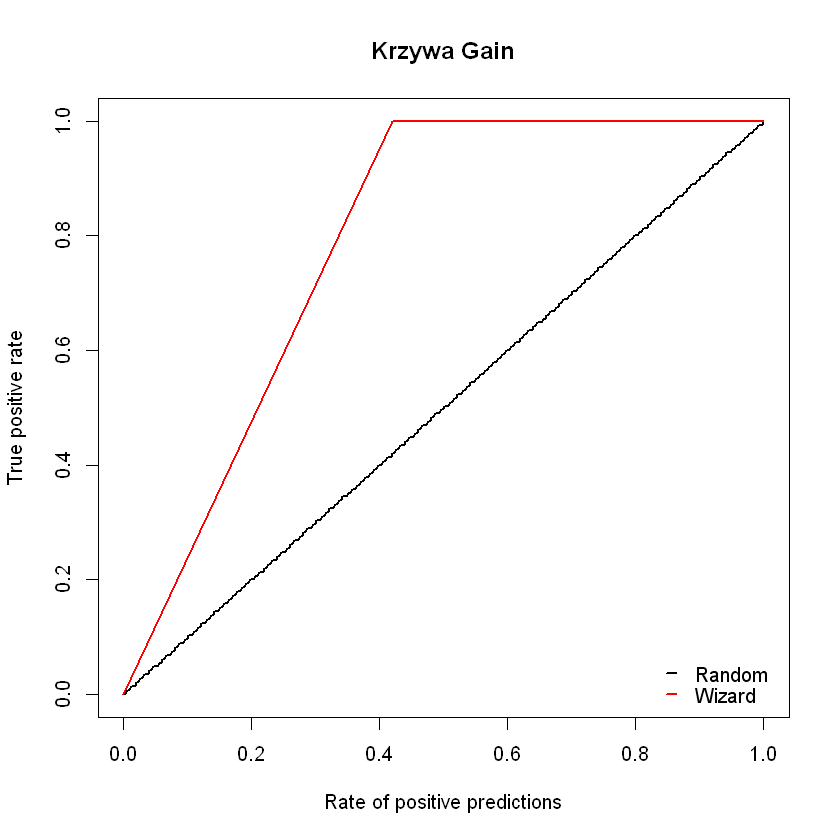

In [12]:
for (i in 1:length(class))
    {
    plot(gain[[i]], main = paste("Krzywa Gain"), col = i, lwd = 2, add = (i != 1),  xlim = c(0, 1))
    legend("bottomright", lty = 1, lwd = 2, col = 1:4, y.intersp = .8,
         legend = c(names(gain)), seg.len = 0.5, bty = "n")
}

Na wykresie widać, że wartości krzywej <i>Random</i> mają postać $RPP(T) = TPR(T)$. Wynika to bezpośrednio z faktu, że klasyfikator przyporządkowuje kategorię całkowicie losowo.
Przebieg krzywej <i>Wizard</i> jest zupełnie inny. Składa się ona z dwóch części: pierwszej, która łączy punkty $(0,0)$ i $(\frac{\sum_{i=1}^{n}[y_i = 1]}{n},1)$ oraz drugiej, która łączy punkty $(\frac{\sum_{i=1}^{n}[y_i = 1]}{n},1)$ i $(1,1)$.
W pierwszym przedziale krzywa <i>Wizard</i> rośnie liniowo do momentu osiągnięcia wartości $1$. Pokazuje ona proporcjonalny wzrost czułości w zależności od liczby obserwacji zaklasyfikowanych jako pozytywne. 
Drugi przedział zaczyna się w momencie w którym $RPP(T)$ osiąga wartość równą prawdziwemu udziałowi pozytywnych obserwacji w zbiorze. Wtedy jest ona stałą zawsze równą 1: $TPP(T) = 1$, co wynika z tego, że klasyfikator idealny zawsze poprawnie klasykifuje zmienne i poprawnie zaklasyfikowanych zmiennych nie może być ani mniej ani więcej niż wynosi ich całkowity udział w zbiorze. 

Dodajmy teraz krzywe dla  oszacowanego logitu na zbiorze trenującym (<i>Train</i>) i na zbiorze testowym (<i>Test</i>):

In [14]:
#generujemy model Train:
class[["Train"]] <- list(predict(BIC.logit, newdata = train.set, type = "response"), train.set$class)
prediction.object[["Train"]] <- prediction(class[["Train"]][[1]],class[["Train"]][[2]])
gain[["Train"]] <- performance(prediction.object[["Train"]], "tpr", "rpp")


In [15]:
#generujemy model Test:
class[["Test"]] <- list(predict(BIC.logit, newdata = test.set, type = "response"), test.set$class)
prediction.object[["Test"]] <- prediction(class[["Test"]][[1]],class[["Test"]][[2]])
gain[["Test"]] <- performance(prediction.object[["Test"]], "tpr", "rpp")


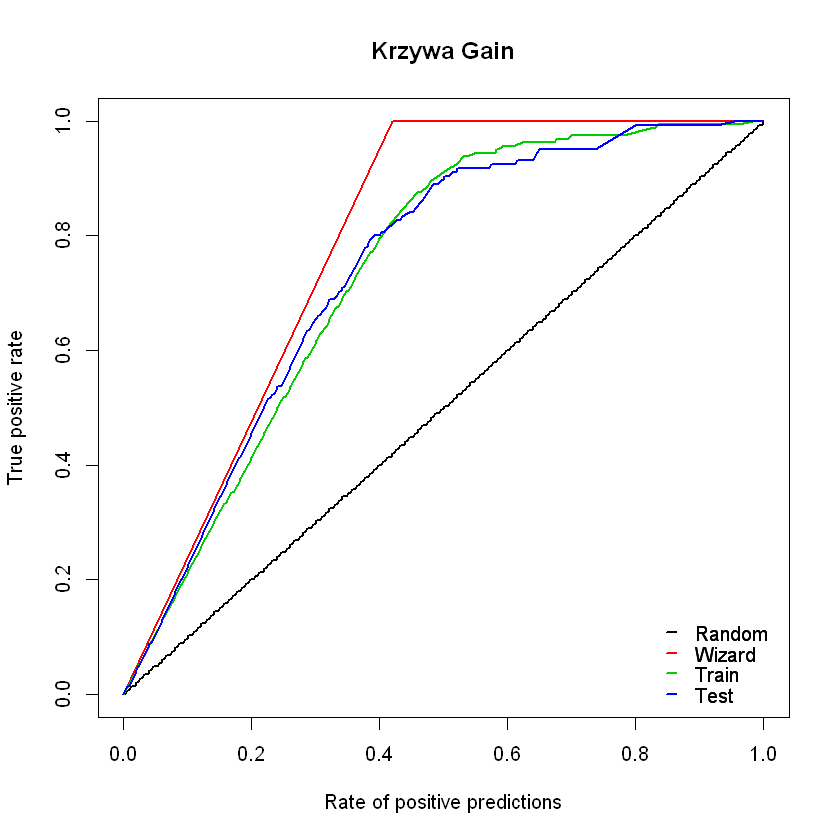

In [16]:
for (i in 1:length(class))
    {
    plot(gain[[i]], main = paste("Krzywa Gain"), col = i, lwd = 2, add = (i != 1),  xlim = c(0, 1))
    legend("bottomright", lty = 1, lwd = 2, col = 1:4, y.intersp = .8,
         legend = c(names(gain)), seg.len = 0.5, bty = "n")
}

Dodanie krzywych dla oszacowanego modelu pozwala nam odczytać kilka ważnych informacji. Przede wszystkim możemy ocenić jakość modelu. Im jest lepszym klasyfikatorem tym jego przebieg jest bliższy krzywej <i>Wizard<i>. Wybierając model chcemy zminimalizować pole powierzchni wyznaczane przez krzywą mu odpowiadającą i krzywą <i>Wizard<i>. 
Ponadto ważna jest informacja na temat tego jak zachowuje się krzywa dla zbioru testowego w stosunku dla tej dla zbioru trenującego. Jeżeli różnica w ich przebiegu jest duża oznacza to, że model nie jest stabilny i prawdopodobnie został przetrenowany.

### 1.2 Krzywa <i>Lift</i>

Kolejną krzywą jest krzywa <i>lift</i>. Można ją traktować jako pochodną krzywej <i>gain</i>, pokazuje ona ilokrotnie wartość krzywej <i>gain</i> danego modelu jest większa niż wartość tej krzywej dla modelu <i>Random</i>.

Wyznaczają ją pary wartości $(RPP(T),LIFT(T))$ gdzie $LIFT(T)$ definiujemy jako: $\frac{TPR(T)}{RPP(T)}$. Najpierw przedstawmy jej wartości dla klasyfikatorów <i>Random</i> i <i>Wizard</i>:

In [25]:
prediction.object[["Random"]]

An object of class "prediction"
Slot "predictions":
[[1]]
  [1] 0.000000000 0.002906977 0.005813953 0.008720930 0.011627907 0.014534884
  [7] 0.017441860 0.020348837 0.023255814 0.026162791 0.029069767 0.031976744
 [13] 0.034883721 0.037790698 0.040697674 0.043604651 0.046511628 0.049418605
 [19] 0.052325581 0.055232558 0.058139535 0.061046512 0.063953488 0.066860465
 [25] 0.069767442 0.072674419 0.075581395 0.078488372 0.081395349 0.084302326
 [31] 0.087209302 0.090116279 0.093023256 0.095930233 0.098837209 0.101744186
 [37] 0.104651163 0.107558140 0.110465116 0.113372093 0.116279070 0.119186047
 [43] 0.122093023 0.125000000 0.127906977 0.130813953 0.133720930 0.136627907
 [49] 0.139534884 0.142441860 0.145348837 0.148255814 0.151162791 0.154069767
 [55] 0.156976744 0.159883721 0.162790698 0.165697674 0.168604651 0.171511628
 [61] 0.174418605 0.177325581 0.180232558 0.183139535 0.186046512 0.188953488
 [67] 0.191860465 0.194767442 0.197674419 0.200581395 0.203488372 0.206395349
 [73] 

In [17]:
#generujemy model Random:a

lift[["Random"]] <- performance(prediction.object[["Random"]], "lift", "rpp")


In [18]:
#generujemy model Wizard:
lift[["Wizard"]] <- performance(prediction.object[["Wizard"]], "lift", "rpp")


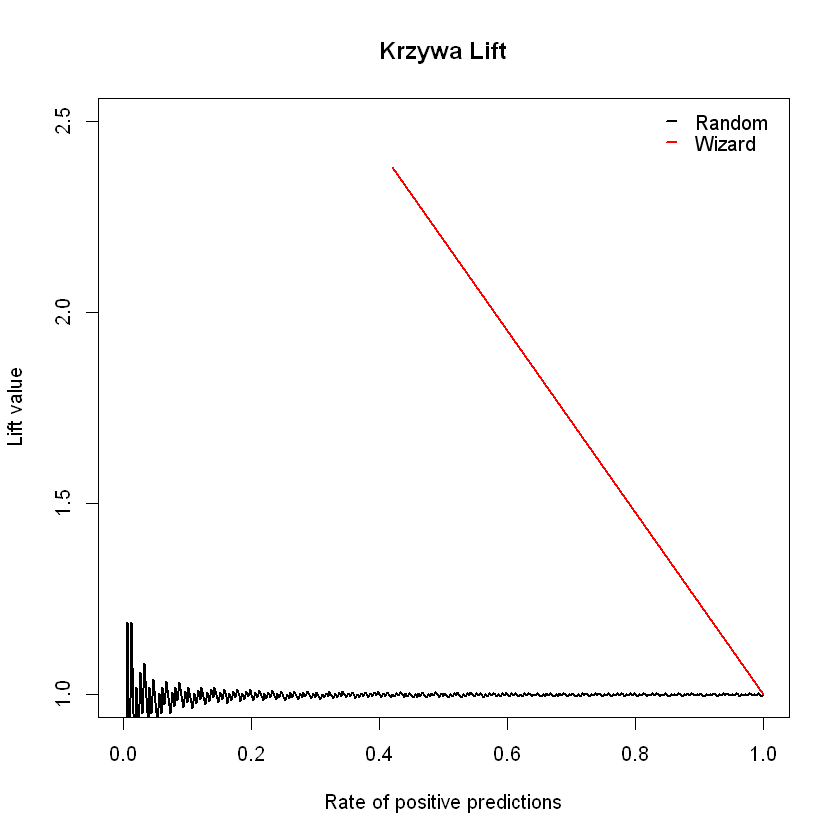

In [19]:
for (i in 1:2)
    {
    plot(lift[[i]], main = paste("Krzywa Lift"), col = i, lwd = 2, add = (i != 1),  xlim = c(0, 1), ylim = c(1,2.5))
    legend("topright", lty = 1, lwd = 2, col = 1:4, y.intersp = .8,
         legend = c(names(lift)), seg.len = 0.5, bty = "n")
}

Dla modelu <i>Random</i> jest ona stała i zawsze wynosi 1, co wynika z jej definicji (różnice na wykresie są skutkiem wielkości próby wykorzystanej do jego tworzenia). 
Dla modelu <i>Wizard</i> w przedziale $(0,\frac{\sum_{i=1}^{n}[y_i = 1]}{n})$ jest ona stała i wynosi $LIFT(T) = \dfrac{1}{\sum_{i=1}^{n}[y_i = 1]/n}$ i następnie spada hiperbolicznie do punktu $(1,1)$. 

Dodajmy krzywe <i>Train</i> i <i>Test</i>:

In [20]:
#generujemy model Train:
lift[["Train"]] <- performance(prediction.object[["Train"]], "lift", "rpp")


In [21]:
#generujemy model Test:
lift[["Test"]] <- performance(prediction.object[["Test"]], "lift", "rpp")


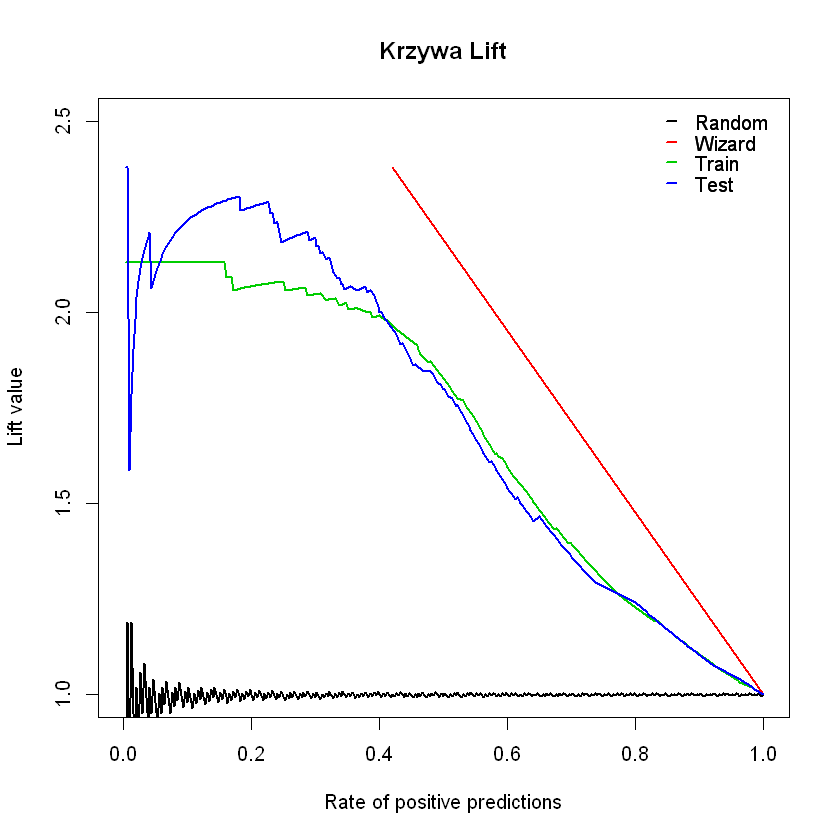

In [22]:
for (i in 1:length(class))
    {
    plot(lift[[i]], main = paste("Krzywa Lift"), col = i, lwd = 2, add = (i != 1),  xlim = c(0, 1), ylim = c(1,2.5))
    legend("topright", lty = 1, lwd = 2, col = 1:4, y.intersp = .8,
         legend = c(names(lift)), seg.len = 0.5, bty = "n")
}

Krzywa <i>lift</i> informuje nas o tym o ile lepszy jest wybrany przez nas model w stosunku do losowego przyporządkowywania kategorii.

### 1.3. Krzywa ROC

Krzywa ROC (<i>Receiver Operating Characteristic<i>) przedstawia uporządkowane pary $(FPR(T),TPR(T))$, gdzie $FPR(T)$ (<i>false positive rate</i>) oznacza stosunek liczby obserwacji fałszywie zaklasyfikowanych jako pozytywne do liczby naprawdę fałszywych obserwacji: $FPR(T) = \dfrac{\sum_{i=1}^{n}[p_i > T \land y_i =0]}{\sum_{i=1}{n} [y_i =0]}$. Wyrażenie $1-FPR(T)$ nazywamy też specyficznością (<i>specificity</i>) klasyfikatora.

Krzywą <i>ROC</i> tworzymy poprzez odkładanie na wykresie wyliczonych dla danego modelu wartości $(FPR(T),TPR(T))$ dla różnych $T \in (0,1)$.

Aby lepiej zrozumieć działanie krzywej ROC przedstawmy na wykresie 2 skrajności: model całkowicie losowy (<i>Random<i>) i model dosknonale prognozujący (<i>Wizard</i>):

In [26]:
#generujemy model Random:
roc[["Random"]] <- performance(prediction.object[["Random"]], "tpr", "fpr")
auc[["Random"]] <- performance(prediction.object[["Random"]], "auc")

In [27]:
#generujemy model Wizard:
roc[["Wizard"]] <- performance(prediction.object[["Wizard"]], "tpr", "fpr")
auc[["Wizard"]] <- performance(prediction.object[["Wizard"]], "auc")

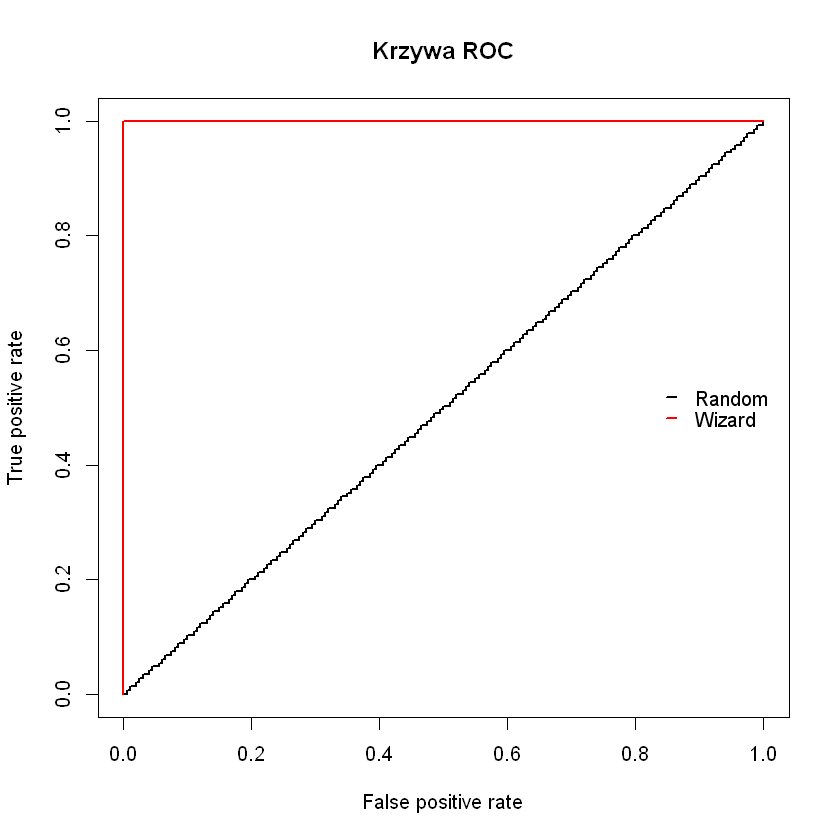

In [28]:
for (i in 1:2)
    {
    plot(roc[[i]], main = paste("Krzywa ROC"), col = i, lwd = 2, add = (i != 1),  xlim = c(0, 1))
    legend("right", lty = 1, lwd = 2, col = 1:4, y.intersp = .8,
         legend = c(names(roc)), seg.len = 0.5, bty = "n")
}

Podobnie jak w przypadku krzywej <i>gain</i>  krzywa <i>Random</i>  ma zawsze równanie $TPR(T) = FPR(T)$. Krzywa <i>Wizard</i> jest de facto jednym punktem $(0,1)$ ($TPR(T) = 1$ i  $FPR(T) =0$).

Dodajmy do wykresu wartości dla oszacowań na zbiorze trenującym i zbiorze testowym:

In [29]:
#generujemy model Train:

roc[["Train"]] <- performance(prediction.object[["Train"]], "tpr", "fpr")
auc[["Train"]] <- performance(prediction.object[["Train"]], "auc")

In [30]:
#generujemy model Test:

roc[["Test"]] <- performance(prediction.object[["Test"]], "tpr", "fpr")
auc[["Test"]] <- performance(prediction.object[["Test"]], "auc")

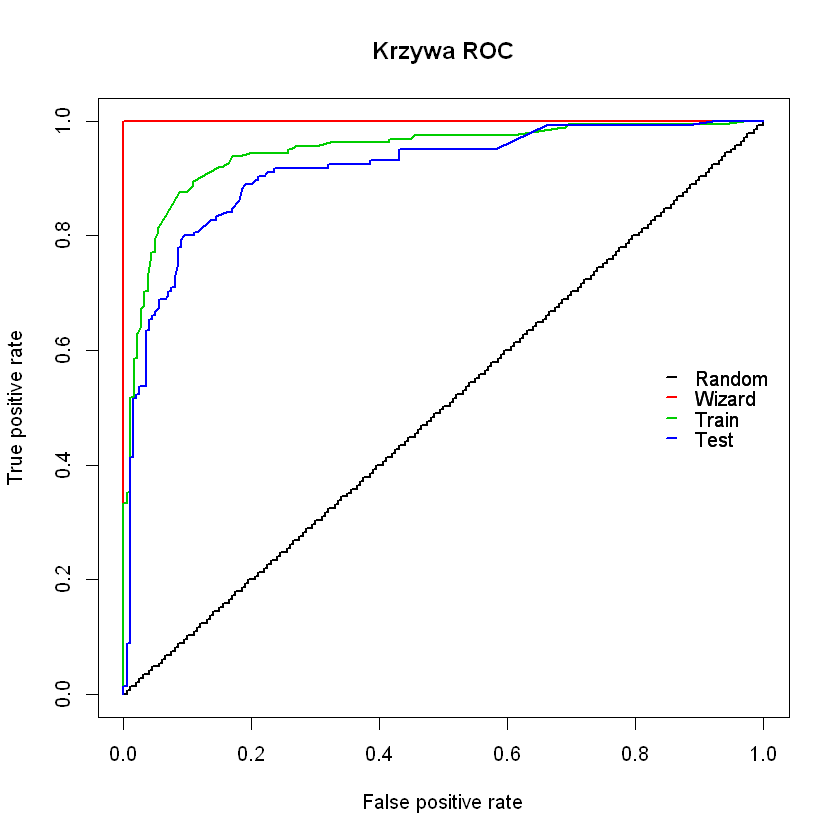

In [31]:
for (i in 1:length(class))
    {
    plot(roc[[i]], main = paste("Krzywa ROC"), col = i, lwd = 2, add = (i != 1),  xlim = c(0, 1))
    legend("right", lty = 1, lwd = 2, col = 1:4, y.intersp = .8,
         legend = c(names(roc)), seg.len = 0.5, bty = "n")
}

Podobnie jak w przypadku krzywej <i>gain</i> wyboru modelu dokonujemy poprzez znalezienie takiego, którego przebieg jest jak najbardziej zbliżony do modelu <i>Wizard</i>. Analogicznie oceniamy też różnice w predykcji modelu pomiędzy zbiorem testowym i zbiorem trenującym.

Ważnym i często wykorzystywanym narzędziem oceny jakości modelu, które wynika bezpośrednio z przebiegu krzywej <i>ROC</i> jest pole powierzchni pod tą krzywą <i>AUC</i> (<i>area under curve</i>). Pozwala ona ocenić jaka jest jakość predykcji modeli niezależnie od wybranego $T$. Dla modelu <i>Wizard</i> pole jest zawsze równe 1 dla modelu <i>Random</i> 0.5. Dodajmy oszacowania <i>AUC</i> do wykresu:

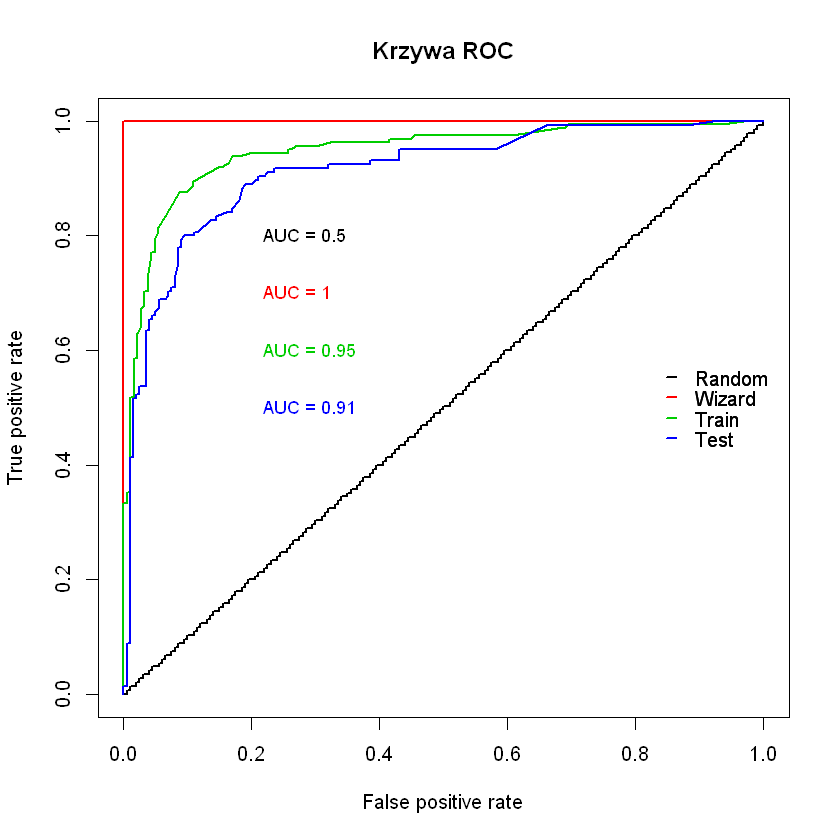

In [32]:
for (i in 1:length(class))
    {
    plot(roc[[i]], main = paste("Krzywa ROC"), col = i, lwd = 2, add = (i != 1),  xlim = c(0, 1))
    legend("right", lty = 1, lwd = 2, col = 1:4, y.intersp = .8,
         legend = c(names(roc)), seg.len = 0.5, bty = "n")
    text(.2, 0.9 - i * 0.1, pos = 4, col = i, cex = .9,
           paste("AUC =", round(auc[[i]]@y.values[[1]], digit = 2)))
}

Ponadto krzywa <i>ROC</i> pozwala na wybór odpowiedniego progu odcięcia $T$. Gdy z góry nic nie zakładamy na jego temat potencjalnym wyborem jest ten gdzie czułość jest równa specyficzności $TPR(T) = 1 - FPR(T)$. Szukamy odpowiedniego punktu na wykresie i odczytujemy wartość. 

Na podstawie krzywej <i>ROC</i> możliwa jest też optymalizacja progu. 

Jak wiemy najlepszy możliwy model to taki, który jest możliwie jak najblżej punktu $(0,1)$. Szukamy więc takiej wartości progu odcięcia, która minimalizuje odległość modelu od tego punktu.

Możliwe jest też wyznaczenie tego w odwrotny sposób - szukając modelu najmocniej oddalonego od krzywej <i>Random</i>. Wykorzystujemy do tego [indeks J Youdena](https://en.wikipedia.org/wiki/Youden's_J_statistic).

### 1.4. Warunkowe funkcje gęstości

Ostatnim wykresem, który wygenerujemy i który pozwoli nam na ocenę jakości predykcji jest warunkowa funkcja gęstości <i>score'u</i> dla klientów, którzy otrzymali kartę kredytową. 

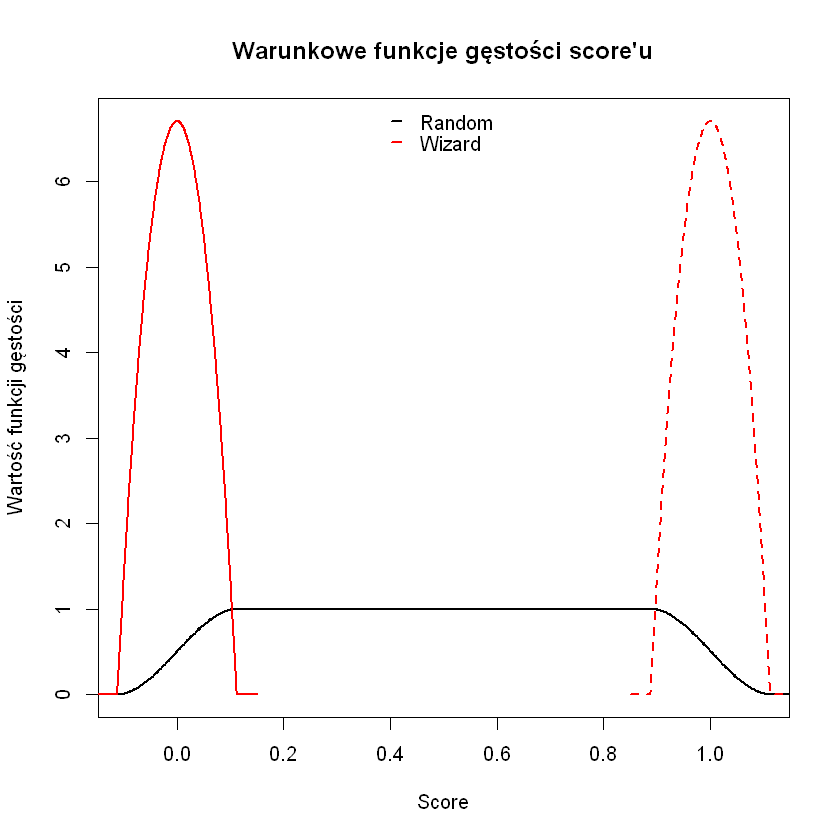

In [33]:
class0.score.density <- class1.score.density <- list()
max.density <- 0
for(i in 1:(length(prediction.object))) {
    predictions <- prediction.object[[i]]@predictions[[1]]
    labels <- prediction.object[[i]]@labels[[1]]
  class0.score.density[[i]] <- density(predictions[labels == "0"],
                                       kernel =  "epanechnikov", bw = 0.05)
  class1.score.density[[i]] <- density(predictions[labels == "1"],
                                       kernel =  "epanechnikov", bw = 0.05)
    max.density <- max(class0.score.density[[i]]$y,
                     class1.score.density[[i]]$y, max.density)
}   
plot(0, 0, type = "n", xlim = c(-0.1, 1.1), ylim = c(0, max.density),
     xlab = "Score", ylab = "Wartość funkcji gęstości",
     main = "Warunkowe funkcje gęstości score'u")
for(i in 1:2) {
    lines(class0.score.density[[i]], col = i, lwd = 2)
    lines(class1.score.density[[i]], col = i, lwd = 2, lty=2)
}   
legend("top", lty = 1, lwd = 2, col=1:4, y.intersp = .8,
         legend = names(prediction.object)[1:2], seg.len = 0.5, bty = "n")


Linią ciągłą narysowana jest funkcja dla etykiety 0 a przerywaną dla etykiety 1. De facto rozkład dla klasyfikatora idealnego jest skumulowany w 2 punktach: 0 i 1, kształt krzywych jest wynikiem ich wygładzenia. Co ważne, te dwa rozkłady nie pokrywają się. Ich przeciwnieństwem jest rozkład dla klasyfikatora <i>Random</i>, który dla obu etykiet doskonale się pokrywa. 

Dodajmy jeszcze funkcje dla modelu na zbiorach trenującym i testowym:

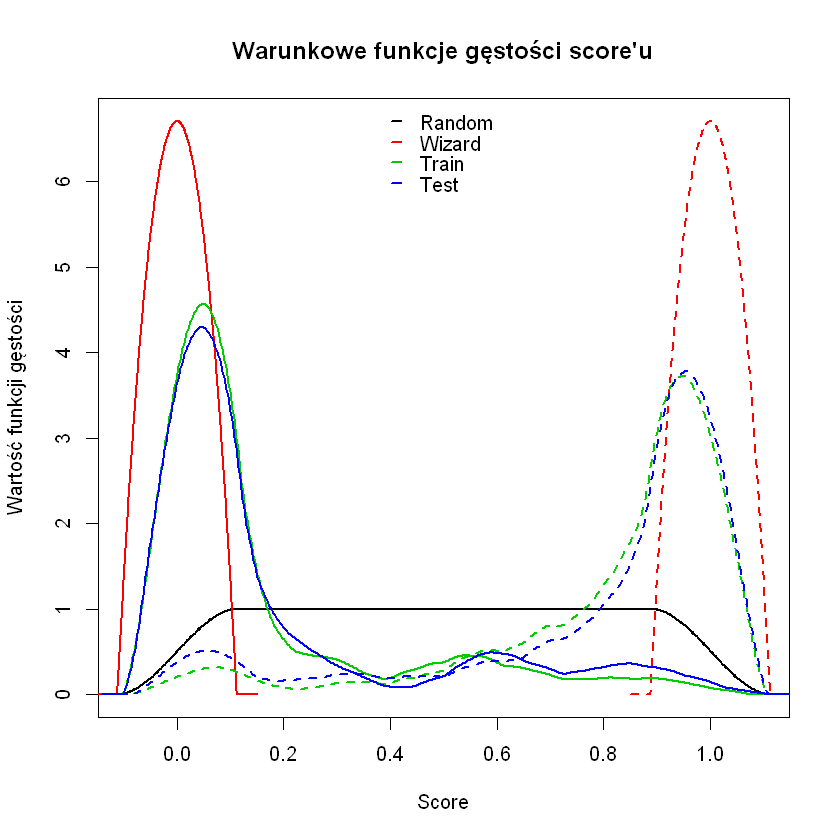

In [34]:
plot(0, 0, type = "n", xlim = c(-0.1, 1.1), ylim = c(0, max.density),
     xlab = "Score", ylab = "Wartość funkcji gęstości",
     main = "Warunkowe funkcje gęstości score'u")
for(i in 1:length(prediction.object)) {
    lines(class0.score.density[[i]], col = i, lwd = 2)
    lines(class1.score.density[[i]], col = i, lwd = 2, lty=2)
}   
legend("top", lty = 1, lwd = 2, col=1:4, y.intersp = .8,
         legend = names(prediction.object), seg.len = 0.5, bty = "n")


Badając warunkowe funkcje gęstości szukamy takich, które jak najlepiej dyskryminują badane zmienne, czyli takich dla których część wspólna na wykresie jest możliwie jak najmniejsza.